In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

import seaborn as sns

In [2]:
np.set_printoptions(suppress=True)

# Download file

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

# Import data

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.0,65+,M,11846,WA,37.0,NaN,1081.0,NaN,1118.0,443.55,271.254275,288
1,2021-01-01,Fri,18379,54.0,45-54,M,1884,WA,40.0,NaN,NaN,NaN,40.0,0.00,40.000000,1
2,2021-01-01,Fri,559232,63.0,55-64,M,2866,WA,NaN,NaN,12.0,NaN,12.0,9.50,2.041720,5
3,2021-01-01,Fri,698904,69.0,65+,M,2100,WA,NaN,NaN,1223.5,NaN,1223.5,267.91,245.117147,40
4,2021-01-01,Fri,762921,67.0,65+,M,4766,WA,NaN,NaN,17.5,NaN,17.5,0.00,3.504075,5


# Clean data and create extra features

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # Impute AGE column
    df['AGE'].fillna(44, inplace=True)

    # Drop redundant columns
    df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]

    # Create YEAR_WEEK column
    df['YEAR_WEEK'] = df['DATE_DIM'].dt.year * 100 + df['DATE_DIM'].dt.week

    # Create RACING_TURNOVER column
    df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)

    # Create WIN_LOSS column
    df['WIN_LOSS'] = (df['DIVIDENDS_PAID'] >= df['TOTAL_TURNOVER']).astype('int32')
    
    return df

df = clean_data(df)

C:\Users\duc.nguyen\AppData\Local\Temp\ipykernel_17916\673612228.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['YEAR_WEEK'] = df['DATE_DIM'].dt.year * 100 + df['DATE_DIM'].dt.week
C:\Users\duc.nguyen\AppData\Local\Temp\ipykernel_17916\673612228.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YEAR_WEEK'] = df['DATE_DIM'].dt.year * 100 + df['DATE_DIM'].dt.week
C:\Users\duc.nguyen\AppData\Local\Temp\ipykernel_17916\673612228.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

# Aggregate

In [8]:
year_week = 202122

pred = df[ (df['YEAR_WEEK'] > year_week ) & (df['YEAR_WEEK'] <= year_week + 4 ) ].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum()

train_12 = df[(df['YEAR_WEEK'] > year_week-12 ) & (df['YEAR_WEEK'] <= year_week)].groupby('BET_ACCOUNT_NUM_HASH').agg({
    'BET_ACCOUNT_NUM_HASH': np.size,
    'AGE_BAND' : max,
    'GENDER' : max,
    'TENURE_IN_DAYS' : max,
    'RACING_TURNOVER' : sum,
    'TOTAL_TURNOVER' : sum,
    'TICKETS' : sum,
    'WIN_LOSS' : sum
})
train_12.columns = map( lambda x : x +"_12", train_12.columns)
train_12 = train_12[train_12['TENURE_IN_DAYS_12'] >= 84]

train_4 = df[(df['YEAR_WEEK'] > year_week-4 ) & (df['YEAR_WEEK'] <= year_week)].groupby('BET_ACCOUNT_NUM_HASH').agg({
    'BET_ACCOUNT_NUM_HASH': np.size,
    'AGE_BAND' : max,
    'GENDER' : max,
    'TENURE_IN_DAYS' : max,
    'RACING_TURNOVER' : sum,
    'TOTAL_TURNOVER' : sum,
    'TICKETS' : sum,
    'WIN_LOSS' : sum
})
train_4.columns = map( lambda x : x +"_4", train_4.columns)

train_1 = df[df['YEAR_WEEK'] == year_week].groupby('BET_ACCOUNT_NUM_HASH').agg({
    'BET_ACCOUNT_NUM_HASH': np.size,
    'AGE_BAND' : max,
    'GENDER' : max,
    'TENURE_IN_DAYS' : max,
    'RACING_TURNOVER' : sum,
    'TOTAL_TURNOVER' : sum,
    'TICKETS' : sum,
    'WIN_LOSS' : sum
})
train_1.columns = map( lambda x : x +"_1", train_1.columns)

# Join data

In [9]:
train = pd.merge(train_12, train_4, left_index=True, right_index=True, how='left')
train = pd.merge(train, train_1, left_index=True, right_index=True, how='left')

In [10]:
train = train.drop(['AGE_BAND_1', 'GENDER_1','AGE_BAND_4', 'GENDER_4','AGE_BAND_12', 'GENDER_12'], axis=1)

train = pd.merge(train, pred, left_index=True, right_index=True, how='left')

train.fillna(0, inplace=True)

train['WIN_LOSS_RATIO_1'] = train['WIN_LOSS_1'] / (train['BET_ACCOUNT_NUM_HASH_1']) 
train['WIN_LOSS_RATIO_4'] = train['WIN_LOSS_4'] / (train['BET_ACCOUNT_NUM_HASH_4']) 
train['WIN_LOSS_RATIO_12'] = train['WIN_LOSS_12'] / (train['BET_ACCOUNT_NUM_HASH_12']) 

train['BET_ACCOUNT_NUM_HASH_1'] = train['BET_ACCOUNT_NUM_HASH_1'] / 7
train['BET_ACCOUNT_NUM_HASH_4'] = train['BET_ACCOUNT_NUM_HASH_4'] /  28
train['BET_ACCOUNT_NUM_HASH_12'] = train['BET_ACCOUNT_NUM_HASH_12'] / 84

train['RACING_RATIO_1'] = train['RACING_TURNOVER_1'] / train['TOTAL_TURNOVER_1']
train['RACING_RATIO_4'] = train['RACING_TURNOVER_4'] / train['TOTAL_TURNOVER_4']
train['RACING_RATIO_12'] = train['RACING_TURNOVER_12'] / train['TOTAL_TURNOVER_12']

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62116 entries, 13154 to 4294891076
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BET_ACCOUNT_NUM_HASH_12  62116 non-null  float64
 1   TENURE_IN_DAYS_12        62116 non-null  int64  
 2   RACING_TURNOVER_12       62116 non-null  float64
 3   TOTAL_TURNOVER_12        62116 non-null  float64
 4   TICKETS_12               62116 non-null  int64  
 5   WIN_LOSS_12              62116 non-null  int32  
 6   BET_ACCOUNT_NUM_HASH_4   62116 non-null  float64
 7   TENURE_IN_DAYS_4         62116 non-null  float64
 8   RACING_TURNOVER_4        62116 non-null  float64
 9   TOTAL_TURNOVER_4         62116 non-null  float64
 10  TICKETS_4                62116 non-null  float64
 11  WIN_LOSS_4               62116 non-null  float64
 12  BET_ACCOUNT_NUM_HASH_1   62116 non-null  float64
 13  TENURE_IN_DAYS_1         62116 non-null  float64
 14  RACING_TURNOV

# Feature selection

In [12]:
train_1 = train.drop(['TENURE_IN_DAYS_1', 'WIN_LOSS_1', 'TENURE_IN_DAYS_4', 'WIN_LOSS_4', 'TENURE_IN_DAYS_12', 'WIN_LOSS_12',
                     'WIN_LOSS_RATIO_1','WIN_LOSS_RATIO_4','WIN_LOSS_RATIO_12','RACING_RATIO_1','RACING_RATIO_4','RACING_RATIO_12'],axis=1)

In [13]:
X = train_1.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_1['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     6655.
Date:                Sat, 01 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:41:42   Log-Likelihood:            -5.8543e+05
No. Observations:               62116   AIC:                         1.171e+06
Df Residuals:                   62103   BIC:                         1.171e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.5464     17.219      1.774      0.076      -3.204      64.297
x1          -568.4920    143.107     -3.973      0.000    -848.982    -288.002
x2            -0.1223      0.004    -29.781      0.000      -0.130      -0.114
x3             0.2186      0.003     74.592      0.000       0.213       0.224
x4             0.0870      0.024      3.635      0.000       0.040       0.134
x5           623.4752    168.500      3.700      0.000     293.215     953.736
x6             1.0664      0.014     75.953      0.000       1.039       1.094
x7            -0.6343      0.010    -65.972      0.000      -0.653      -0.615
x8            -0.4307      0.082     -5.237      0.000      -0.592      -0.269
x9           849.1764     94.118      9.022      0.000     664.705    1033.648
x10           -2.3817      0.039    -61.823      0.000      -2.457      -2.306
x11            2.4871      0.034     72.091      0.000       2.419       2.555
x12            1.6000      0.155     10.307      0.000       1.296       1.904
==============================================================================
Omnibus:                   107080.157   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2541072148.197
Skew:                          10.828   Prob(JB):                         0.00
Kurtosis:                     993.623   Cond. No.                     3.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
y_pred = results.predict(X)

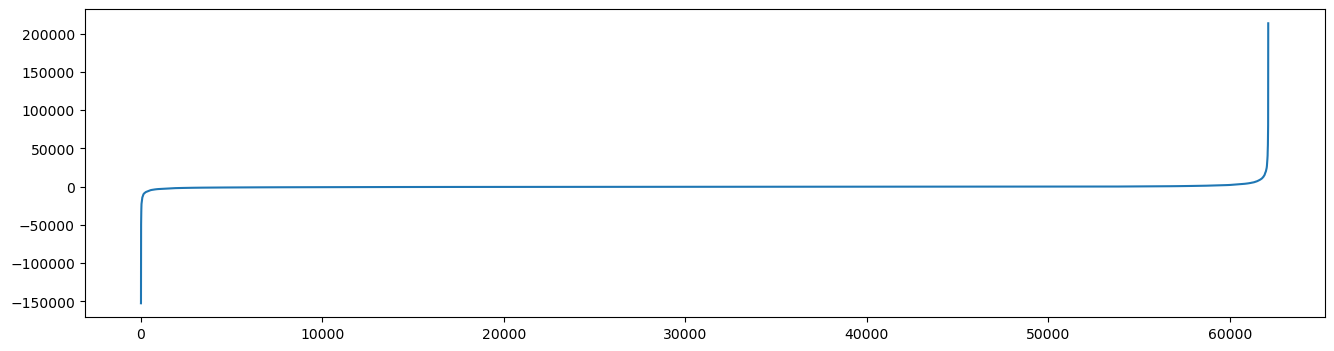

In [15]:
e = y.flatten()  - y_pred

e.sort()

plt.figure(figsize=(16,4))
plt.plot(e )

In [16]:
y.flatten()

array([18536.14,   602.  ,    17.  , ...,    20.  , 11528.  ,  2582.  ])

In [17]:
y_pred

array([23222.43183754,   874.32289193,    47.50601655, ...,
          50.64122045,  3171.43260706,  2595.28783886])

In [18]:
(sum(e**2)/63433)

8802564.951456672

In [19]:
(sum(e**2)/63433)**0.5

2966.9116858202356

In [20]:
train_2 = train.drop(['TENURE_IN_DAYS_1', 'WIN_LOSS_1', 'TENURE_IN_DAYS_4', 'WIN_LOSS_4', 'TENURE_IN_DAYS_12', 'WIN_LOSS_12',
                     'WIN_LOSS_RATIO_1','WIN_LOSS_RATIO_4','WIN_LOSS_RATIO_12','RACING_RATIO_1','RACING_RATIO_4','RACING_RATIO_12',
                     'BET_ACCOUNT_NUM_HASH_4', 'BET_ACCOUNT_NUM_HASH_12'],axis=1)

In [21]:
X = train_2.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_2['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     7983.
Date:                Sat, 01 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:41:42   Log-Likelihood:            -5.8543e+05
No. Observations:               62116   AIC:                         1.171e+06
Df Residuals:                   62105   BIC:                         1.171e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.5439     15.621      0.931      0.352     -16.074      45.162
x1            -0.1240      0.004    -30.317      0.000      -0.132      -0.116
x2             0.2178      0.003     74.536      0.000       0.212       0.224
x3             0.0663      0.023      2.842      0.004       0.021       0.112
x4             1.0724      0.014     76.822      0.000       1.045       1.100
x5            -0.6324      0.010    -65.869      0.000      -0.651      -0.614
x6            -0.3654      0.081     -4.534      0.000      -0.523      -0.207
x7           951.6039     45.362     20.978      0.000     862.695    1040.513
x8            -2.3872      0.039    -62.000      0.000      -2.463      -2.312
x9             2.4871      0.034     72.168      0.000       2.420       2.555
x10            1.5573      0.153     10.158      0.000       1.257       1.858
==============================================================================
Omnibus:                   107070.804   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2532514807.004
Skew:                          10.827   Prob(JB):                         0.00
Kurtosis:                     991.953   Cond. No.                     6.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
y_pred = results.predict(X)
y_pred

array([23178.83333946,   863.12024376,    22.90144559, ...,
          19.28424399,  3170.08306865,  2536.50691889])

In [23]:
y

array([[18536.14],
       [  602.  ],
       [   17.  ],
       ...,
       [   20.  ],
       [11528.  ],
       [ 2582.  ]])

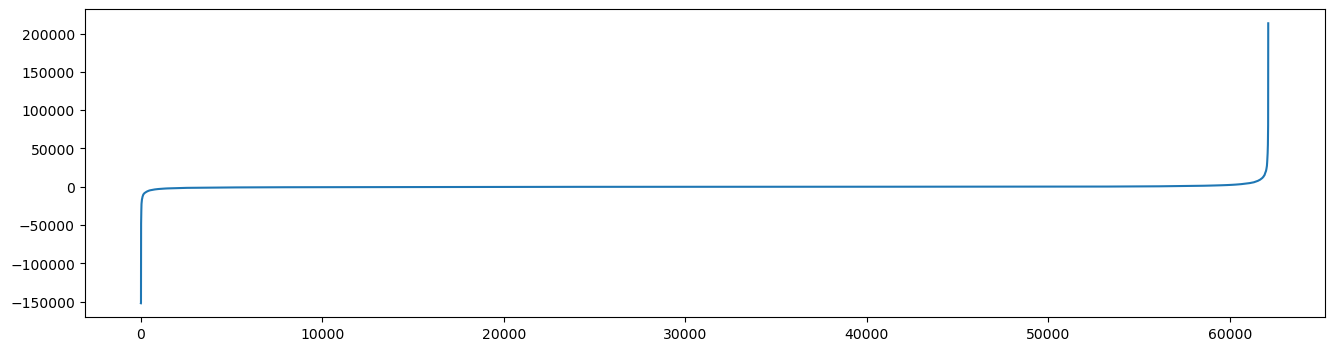

In [24]:
y_pred = results.predict(X)
e = y.flatten()  - y_pred

e.sort()

plt.figure(figsize=(16,4))
plt.plot(e )

In [25]:
(sum(e**2)/63433)

8804934.314752638

In [26]:
(sum(e**2)/63433)**0.5

2967.3109568686323

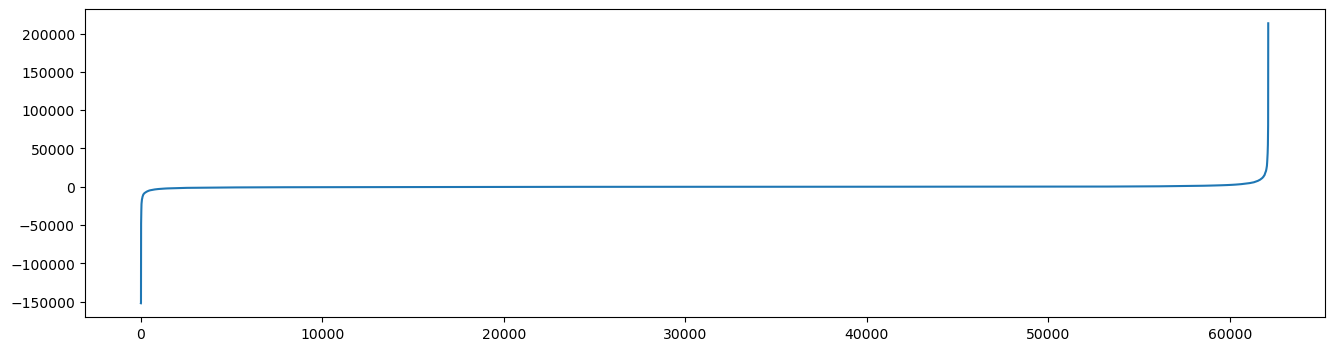

In [27]:
y_pred = results.predict(X)
e = y.flatten()  - y_pred

e.sort()

plt.figure(figsize=(16,4))
plt.plot(e )

In [28]:
train.columns

Index(['BET_ACCOUNT_NUM_HASH_12', 'TENURE_IN_DAYS_12', 'RACING_TURNOVER_12',
       'TOTAL_TURNOVER_12', 'TICKETS_12', 'WIN_LOSS_12',
       'BET_ACCOUNT_NUM_HASH_4', 'TENURE_IN_DAYS_4', 'RACING_TURNOVER_4',
       'TOTAL_TURNOVER_4', 'TICKETS_4', 'WIN_LOSS_4', 'BET_ACCOUNT_NUM_HASH_1',
       'TENURE_IN_DAYS_1', 'RACING_TURNOVER_1', 'TOTAL_TURNOVER_1',
       'TICKETS_1', 'WIN_LOSS_1', 'TOTAL_TURNOVER', 'WIN_LOSS_RATIO_1',
       'WIN_LOSS_RATIO_4', 'WIN_LOSS_RATIO_12', 'RACING_RATIO_1',
       'RACING_RATIO_4', 'RACING_RATIO_12'],
      dtype='object')

In [29]:
train_3 = train[['TOTAL_TURNOVER_12', 'TOTAL_TURNOVER_4', 'TOTAL_TURNOVER_1', 'TOTAL_TURNOVER', 'BET_ACCOUNT_NUM_HASH_12']]

In [30]:
X = train_3.drop('TOTAL_TURNOVER', axis=1).to_numpy()
y = train_3['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

#X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.543
Method:                 Least Squares   F-statistic:                          1.843e+04
Date:                Sat, 01 Jul 2023   Prob (F-statistic):                        0.00
Time:                        15:41:43   Log-Likelihood:                     -5.8879e+05
No. Observations:               62116   AIC:                                  1.178e+06
Df Residuals:                   62112   BIC:                                  1.178e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1823      0.002     95.245      0.000       0.179       0.186
x2            -0.0469      0.006     -7.539      0.000      -0.059      -0.035
x3             0.7420      0.013     56.315      0.000       0.716       0.768
x4          1283.1279     38.457     33.365      0.000    1207.751    1358.505
==============================================================================
Omnibus:                    80355.692   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4048735477.220
Skew:                           5.505   Prob(JB):                         0.00
Kurtosis:                    1253.682   Cond. No.                     4.39e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
y_pred = results.predict(X)

In [32]:
y_pred

array([20065.47155663,   673.94837572,    33.26504799, ...,
          16.6299442 ,  3404.37615327,  1967.51188806])

In [33]:
y

array([[18536.14],
       [  602.  ],
       [   17.  ],
       ...,
       [   20.  ],
       [11528.  ],
       [ 2582.  ]])

In [34]:
sum((y.flatten() - y_pred)**2)/62116

10019260.495093474

In [35]:
(sum((y.flatten() - y_pred)**2)/62116)**0.5

3165.321546872209

In [36]:
train.columns

Index(['BET_ACCOUNT_NUM_HASH_12', 'TENURE_IN_DAYS_12', 'RACING_TURNOVER_12',
       'TOTAL_TURNOVER_12', 'TICKETS_12', 'WIN_LOSS_12',
       'BET_ACCOUNT_NUM_HASH_4', 'TENURE_IN_DAYS_4', 'RACING_TURNOVER_4',
       'TOTAL_TURNOVER_4', 'TICKETS_4', 'WIN_LOSS_4', 'BET_ACCOUNT_NUM_HASH_1',
       'TENURE_IN_DAYS_1', 'RACING_TURNOVER_1', 'TOTAL_TURNOVER_1',
       'TICKETS_1', 'WIN_LOSS_1', 'TOTAL_TURNOVER', 'WIN_LOSS_RATIO_1',
       'WIN_LOSS_RATIO_4', 'WIN_LOSS_RATIO_12', 'RACING_RATIO_1',
       'RACING_RATIO_4', 'RACING_RATIO_12'],
      dtype='object')

In [37]:
train_3 = train[['TOTAL_TURNOVER_12', 'TOTAL_TURNOVER_4', 'TOTAL_TURNOVER_1', 'TOTAL_TURNOVER', 'BET_ACCOUNT_NUM_HASH_12', 'WIN_LOSS_RATIO_12']]

In [38]:
X = train_3.drop('TOTAL_TURNOVER', axis=1).to_numpy() 
y = train_3['TOTAL_TURNOVER'].to_numpy().reshape(-1,1) 

X_log = np.log(X+1)
y_log = np.log(y+1)
#X = sm.add_constant(X)

model = sm.OLS(y_log, X_log) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                          8.886e+04
Date:                Sat, 01 Jul 2023   Prob (F-statistic):                        0.00
Time:                        15:41:43   Log-Likelihood:                     -1.2493e+05
No. Observations:               62116   AIC:                                  2.499e+05
Df Residuals:                   62111   BIC:                                  2.499e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2513      0.003     73.003      0.000       0.245       0.258
x2             0.3142      0.005     62.476      0.000       0.304       0.324
x3             0.2973      0.005     63.277      0.000       0.288       0.306
x4             2.2140      0.060     36.935      0.000       2.096       2.331
x5            -0.2800      0.049     -5.739      0.000      -0.376      -0.184
==============================================================================
Omnibus:                     2787.599   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7534.673
Skew:                          -0.221   Prob(JB):                         0.00
Kurtosis:                       4.648   Cond. No.                         74.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
y_pred_log = results.predict(X_log)

In [40]:
y_pred = np.exp(y_pred_log)-1
y_pred

array([20018.92914043,   251.78573016,     4.44720574, ...,
           2.28078134,  2405.66018863,  1809.86344686])

In [41]:
y_pred[:10]

array([20018.92914043,   251.78573016,     4.44720574,   430.86344505,
          12.76011779,   206.8399784 ,  4860.85700167,   458.39425613,
           3.78393145,   900.87605156])

In [42]:
y.flatten()[:10]

array([18536.14,   602.  ,    17.  ,   262.5 ,     0.  ,   854.  ,
       11525.5 ,   944.5 ,     9.  ,  1019.16])

In [43]:
sum((y.flatten() - y_pred)**2)/62116

9766808.986810058

In [44]:
(sum((y.flatten() - y_pred)**2)/62116)**0.5

3125.189432148083

In [45]:
e = y.flatten() - y_pred
e

array([-1482.78914043,   350.21426984,    12.55279426, ...,
          17.71921866,  9122.33981137,   772.13655314])

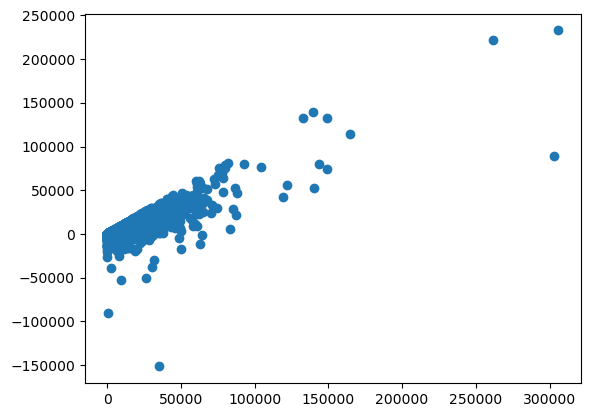

In [46]:
plt.scatter(train_3['TOTAL_TURNOVER'], e)


# Regression tree

In [47]:
X = train.drop(['TOTAL_TURNOVER', 'RACING_RATIO_1', 'RACING_RATIO_4', 'WIN_LOSS_RATIO_1', 'WIN_LOSS_RATIO_4'], axis=1)
y = train['TOTAL_TURNOVER']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
for i in range(3,26,1):
    tree_clf = DecisionTreeRegressor(max_depth=i
#                                     ,min_weight_fraction_leaf=0.05
                                    )
    tree_clf.fit(X_train,y_train)
    
    y_pred = tree_clf.predict(X_test)
    e = y_test - y_pred
    mse = sum(e**2)/15529
    
    print(str(i) + " : ", mse)

3 :  10631608.60124421
4 :  10860627.062908558
5 :  14062156.722862473
6 :  18912941.658019908
7 :  17447945.7073563
8 :  20436481.174651567
9 :  18756633.08189339
10 :  17361368.648837235
11 :  20264589.809134264
12 :  20422819.46913335
13 :  19623965.495065518
14 :  21973619.828649033
15 :  21421143.87504744
16 :  23192403.738665737
17 :  21609505.412593383
18 :  23029959.0566522
19 :  22043609.750684425
20 :  22835968.27820897
21 :  23159233.03858813
22 :  21500987.659631122
23 :  22072591.759136826
24 :  21896874.01448072
25 :  19468827.25654443


In [50]:
for i in range(3,26):
    tree_clf = DecisionTreeRegressor(max_depth=i, min_weight_fraction_leaf=0.05)
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(tree_clf, X, y, cv=kfold, scoring = 'neg_mean_squared_error')
    
    print(str(i) + " : ", scores.mean())

3 :  -14380714.436714029
4 :  -14357021.951691251
5 :  -14350121.113211695
6 :  -14349056.092577005
7 :  -14348861.407989627
8 :  -14348826.799000368
9 :  -14348826.398971368
10 :  -14348826.7417658
11 :  -14348826.741765797
12 :  -14348826.7417658
13 :  -14348826.7417658
14 :  -14348826.7417658
15 :  -14348826.7417658
16 :  -14348826.741765797
17 :  -14348826.7417658
18 :  -14348826.7417658
19 :  -14348826.7417658
20 :  -14348826.7417658
21 :  -14348826.7417658
22 :  -14348826.7417658
23 :  -14348826.7417658
24 :  -14348826.7417658
25 :  -14348826.741765797
